In [46]:
import json
import string
from nltk.corpus import stopwords
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext

ModuleNotFoundError: No module named 'word2vecReader'

In [17]:
def load_data(filename):
    with open(filename,'r') as fin:
        return json.load(fin)

In [18]:
dataset_dict = load_data("dataset/final_dataset.json")

In [19]:
def extract_data(dataset_dict):
    review = [dataset_dict[key]["review"] for key in dataset_dict.keys()]
    polarity = [dataset_dict[key]["polarity"] for key in dataset_dict.keys()]
    return review, polarity 

In [20]:
review, polarity = extract_data(dataset_dict)

In [21]:
len(review),len(polarity)

(2000, 2000)

In [22]:
def clean_sentence(sentence):
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #for PYTHON 2.7
    #tokens = [w.translate(None, string.punctuation) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [30]:
review = [clean_sentence(s) for s in review]

In [31]:
length = [len(s) for s in review]

(array([117., 715., 734., 283., 105.,  32.,  11.,   2.,   0.,   1.]),
 array([   52. ,  1095.3,  2138.6,  3181.9,  4225.2,  5268.5,  6311.8,
         7355.1,  8398.4,  9441.7, 10485. ]),
 <a list of 10 Patch objects>)

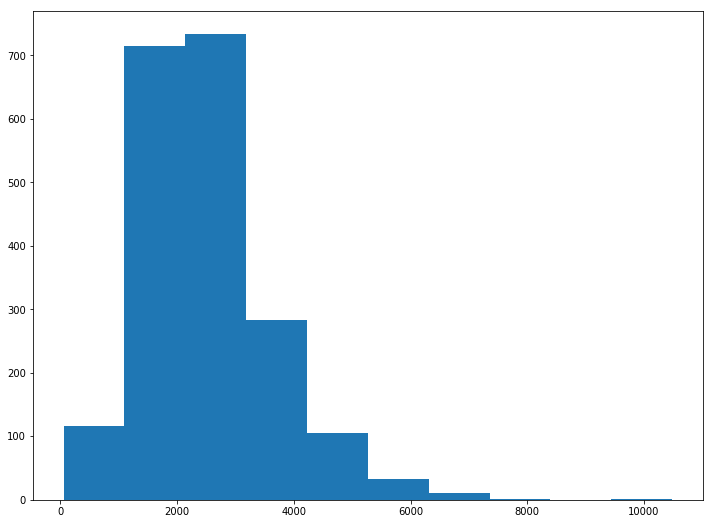

In [41]:
plt.hist(length)

In [43]:
max_len = 6500

In [44]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [45]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded